# Food-101 using ResNet50 with fastai

## Contents:

- Overview
- Loading data
- Division into training, validation, and test data
- Exploration of data
- Define model
- Train model
- Test model (Basic and TTA)
- Exploration of failures
- Conclusions

## Overview

I am practicing my AI and data science skills in various mini-projects. One has been classifying the images in the Food-101 dataset.
After being unsatisfied with the model trained by my implementation in pytorch (https://github.com/ruthschulz/data_science_playground/blob/master/food_101-resnet50-pytorch.ipynb), I decided to try the fastai approach from lesson 1 of their online course: Practical Deep Learning for Coders, v3 (https://course.fast.ai/videos/?lesson=1). I haven't used fastai before, so I'm sure I haven't found all of the good methods to use for everything I have done here.

I came across this dataset while looking at data science fellowships, one of which being Fellowship.ai. (https://fellowship.ai/)
As part of their application process they have several challenges to complete, including one using the Food-101 dataset.

The initial model I implemented in keras achieved about 60% accuracy on the test set.
The model I implemented in pytorch reaches a top-1 accuracy of 75.8% and a top-5 accuracy of 93.0%.

The model trained here reaches a top-1 accuracy of 85.56% and a top-5 accuracy of 97.12%.

I have used google colab to train the model, which has been excellent, although it does have a tendancy to reset the runtime every so often, so I have found it helpful to often save the current state of the model and to have the dataset on google drive ready to copy across rather than re-download.
https://colab.research.google.com


### Food-101

https://www.vision.ee.ethz.ch/datasets_extra/food-101/

This dataset contains images of foods from 101 categories.
Files are also provided that divide the dataset up into training and test sets (respectively containing 750 and 250 images of each category)

The original paper used Random Forests for classification and reached 56.40% accuracy.

I have also found a paper that reached 77.4% accuracy using a GoogLeNet model pre-trained on ImageNet and finetuned using Food-101. https://arxiv.org/abs/1606.05675

The following reached 86.97% Top-1 Accuracy and 97.42% Top-5 Accuracy
https://github.com/stratospark/food-101-keras


### Fellowship.ai Challenge: 

https://fellowship.ai/challenge

"Food-101 is a challenging vision problem, but everyone can relate to it.  Recent SoTA is ~80% top-1, 90% top-5.  These approaches rely on lots of TTA, large networks and  even novel architectures.

Train a decent model >85% accuracy for top-1 for the test set, using a ResNet50 or smaller network with a reasonable set of augmentations."

- SoTA = State of the Art
- top-1 = if the correct category is the top category chosen by the model
- top-5 = if the correct category is in the top five categories chosen by the model
- TTA = Test Time Augmentation (generate the prediction using the model X times using different augmentations e.g. flip horizontal or zoom, then select the category with the highest mean value)

## Loading Data

The Food-101 dataset is available at https://www.vision.ee.ethz.ch/datasets_extra/food-101/

This dataset can be loaded to google colab using:

!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

!tar xzvf food-101.tar.gz

The dataset is also available on Kaggle at https://www.kaggle.com/dansbecker/food-101

Kaggle datasets can be loaded to google colab using the instructions here:

https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463

Then the dataset can be unzipped using:

!unzip -o -q \food-101.zip

After I got annoyed with waiting to download the data again every time the runtime reset, I copied the dataset to my google drive and copied it back into runtime when needed.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 16

In [0]:
# Mount google drive for easy access to dataset 
# and for transferring across saved models
import os
if not os.path.exists("./gdrive"):
  from google.colab import drive
  drive.mount('/content/gdrive')

In [0]:
# Copy across dataset and unzip
import shutil
if not os.path.exists("./food-101"):
  shutil.copyfile( './gdrive/My Drive/Colab Notebooks/food-101.tar.gz', 'food-101.tar.gz')
  !tar xzf food-101.tar.gz   

## Division into Training, Validation, and Test sets

Part of the meta data included with the Food-101 dataset is the training / test split used in the initial paper.

As the definition of the fellowship.ai challenge indicated that the target was to achieve 85% accuracy on the test set, I have used the defined training and test set.

No validation set has been assigned, and I have created one here that is 10% of the training set.

Train, validation, and test set can by specified by separating out into folders, but fastai assumes that the test set is without labels, so I have defined an ImageDataBunch.from_folder for the training and validation set and another one for the test set.

In [0]:
# Separate out test set from training set as specified in meta/test.txt
if not os.path.exists("./food-101/test_data/train"):

  test_file = open("./food-101/meta/test.txt","r")
  current_cat = ""
  for line in test_file:
      [category,index] = line.split('/')
      if (category != current_cat):
          current_cat = category
          if not os.path.exists("./food-101/test_data/train/" + current_cat):
              os.makedirs("./food-101/test_data/train/" + current_cat)
      shutil.move("./food-101/images/" + line[:-1] + ".jpg","./food-101/test_data/train/" + line[:-1] + ".jpg")
  test_file.close()

In [0]:
# Create a validation set:
# for all classes
# choose random 10% of images (75 out of 750 training images)
# move to validation folder
import random

if not os.path.isfile('./gdrive/My Drive/Colab Notebooks/valid.txt'):

  train_file = open("./food-101/meta/train.txt","r")
  lines = train_file.readlines()
  train_file.close()

  valid_file = open("./food-101/meta/valid.txt","w")
  
  current_cat = ""
  for food_index in range(n_classes):
    indexes = []
    for i in range(int(train_set_size / 10)):
      rand_index = random.randint(0,train_set_size)
      while (rand_index in indexes):
        rand_index = random.randint(0,train_set_size)
      indexes.append(rand_index)
    indexes.sort()
    for img_index in range(int(train_set_size / 10)):
      gen_index = 0
      while(indexes[img_index] > gen_index):
        gen_index = gen_index + 1
      valid_file.write(lines[(food_index * train_set_size)+gen_index])

  valid_file.close()
  shutil.copyfile( 'valid.txt', './gdrive/My Drive/Colab Notebooks/valid.txt')

In [0]:
# Initialise class_list and n_classes
class_file = open("./food-101/meta/classes.txt")
class_list = []
for line in class_file:
    [cat,other] = line.split('\n')
    class_list.append(cat)
class_file.close()
print(class_list)
n_classes = len(class_list)
num_train_images = 75750
num_test_images = 25250
train_set_size = int(num_train_images / n_classes)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [0]:
# Separate out validation set from training set as specified in meta/valid.txt
if not os.path.exists("./food-101/data/valid"):

  #valid_file = open("./food-101/meta/valid.txt","r")
  valid_file = open("./gdrive/My Drive/Colab Notebooks/valid.txt")
  current_cat = ""
  for line in valid_file:
      [category,index] = line.split('/')
      if (category != current_cat):
          current_cat = category
          if not os.path.exists("./food-101/data/valid/" + current_cat):
              os.makedirs("./food-101/data/valid/" + current_cat)
      shutil.move("./food-101/images/" + line[:-1] + ".jpg","./food-101/data/valid/" + line[:-1] + ".jpg")
  valid_file.close()
  
num_train_images = int(num_train_images - n_classes * (train_set_size / 10))
num_valid_images = int(n_classes * (train_set_size / 10))

In [0]:
shutil.copytree('./food-101/images', './food-101/data/train')

'./food-101/data/train'

In [0]:
shutil.copytree('./food-101/test_data/train', './food-101/test_data/valid')

'./food-101/test_data/valid'

In [0]:
path_test_img = './food-101/test_data'

In [0]:
path_img = './food-101/data'

In [0]:
data = ImageDataBunch.from_folder(path_img, ds_tfms=get_transforms(), size=299, bs=bs
                                  ).normalize(imagenet_stats)

In [0]:
test_data = ImageDataBunch.from_folder(path_test_img, ds_tfms=get_transforms(), size=299, bs=bs).normalize(imagenet_stats)

## Exploration of Data

From the website:
"We introduce a challenging data set of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.""

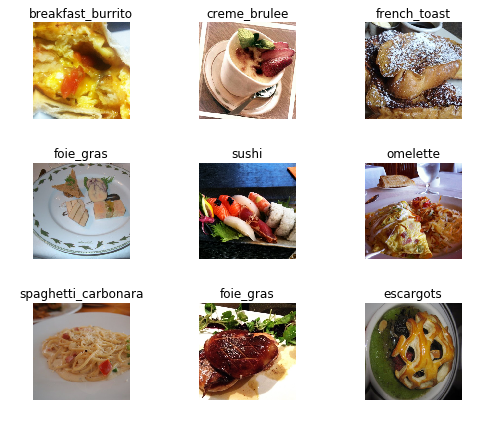

In [0]:
data.show_batch(rows=3, figsize=(7,6))

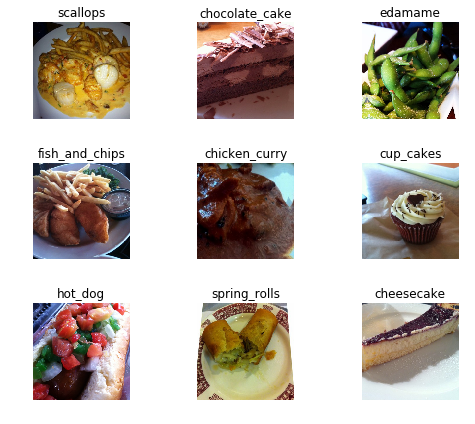

In [0]:
test_data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)
len(data.classes),data.c

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

(101, 101)

## Define Model

Using cnn_learner from fastai extending ResNet50 trained on the ImageNet dataset. This network adds a few layers at the end of ResNet50 to classify the 101 classes:
- AdaptiveConcatPool2d with AdaptiveAvgPool2d and  AdaptiveMaxPool2d
- Flatten
- BatchNorm1d
- Dropout(p=0.25)
- Linear(4096 to 512)
- ReLU
- BatchNorm1d
- Dropout(p=0.5)
- Linear(512 to 101)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


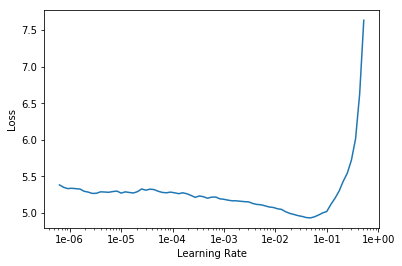

In [0]:
learn.lr_find()
learn.recorder.plot()

## Train model

The suggested fastai method is to use fit_one_cycle, which uses a cyclic learning rate. The model is trained for 8 epochs, then the ResNet50 layers are unfreezed and the model is trained for another 4 epochs.

In [0]:
learn.fit_one_cycle(8)
learn.save('stage-1')
shutil.copyfile('./food-101/data/models/stage-1.pth', './gdrive/My Drive/Colab Notebooks/models/stage-1.pth')

epoch,train_loss,valid_loss,error_rate,time
0,1.956850,1.526799,0.394851,24:47
1,1.785286,1.340159,0.353531,24:03
2,1.548129,1.192035,0.317756,24:13
3,1.387859,1.091460,0.289109,24:18
4,1.364789,1.003064,0.266535,23:52
5,1.170380,0.946278,0.250429,23:47
6,1.171641,0.913806,0.243168,23:50
7,1.103028,0.911053,0.243300,23:48


'./gdrive/My Drive/Colab Notebooks/models/stage-1.pth'

In [0]:
learn.export('trained_model.pkl')
shutil.copyfile('./food-101/data/trained_model.pkl', './gdrive/My Drive/Colab Notebooks/models/trained_model1.pkl')

'./gdrive/My Drive/Colab Notebooks/models/trained_model1.pkl'

In [0]:
# if restarting notebook from here, load model
if not os.path.exists("./food-101/data/models"):
  os.mkdir('./food-101/data/models')
shutil.copyfile('./gdrive/My Drive/Colab Notebooks/models/stage-1.pth', './food-101/data/models/stage-1.pth')
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (68175 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
sashimi,sashimi,sashimi,sashimi,sashimi
Path: food-101/data;

Valid: LabelList (7575 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
sashimi,sashimi,sashimi,sashimi,sashimi
Path: food-101/data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))
learn.save('stage-2')
shutil.copyfile('./food-101/data/models/stage-2.pth', './gdrive/My Drive/Colab Notebooks/models/stage-2.pth')

epoch,train_loss,valid_loss,error_rate,time
0,1.141411,0.877234,0.235908,26:09
1,0.965336,0.815271,0.219538,26:18
2,0.928406,0.779323,0.207657,26:15
3,0.828523,0.773258,0.206601,26:23


'./gdrive/My Drive/Colab Notebooks/models/stage-2.pth'

In [0]:
learn.export('trained_model.pkl')
shutil.copyfile('./food-101/data/trained_model.pkl', './gdrive/My Drive/Colab Notebooks/models/trained_model2.pkl')

'./gdrive/My Drive/Colab Notebooks/models/trained_model2.pkl'

In [0]:
# if restarting notebook from here, load model
if not os.path.exists("./food-101/data/models"):
  os.mkdir('./food-101/data/models')
shutil.copyfile('./gdrive/My Drive/Colab Notebooks/models/stage-2.pth', './food-101/data/models/stage-2.pth')
learn.load('stage-2')

## Test model (Basic and TTA)

First basic accuracy of predictions, then top-5, then top-1 using TTA, then top-5 using TTA

The model trained here reaches:
- training accuracy of 84.42%
- validation accuracy of 79.34%
- test accuracy of 84.42%

When TTA is also used, the model reaches a top-1 accuracy of 85.56% and a top-5 accuracy of 97.12%.



In [0]:
learn.data = data

In [0]:
interp_train = ClassificationInterpretation.from_learner(learn, DatasetType.Train) # train

In [0]:
interp_valid = ClassificationInterpretation.from_learner(learn, DatasetType.Valid)

In [0]:
learn.data = test_data

In [0]:
interp_test = ClassificationInterpretation.from_learner(learn)

In [0]:
interp_test_tta = ClassificationInterpretation.from_learner(learn, tta=True)

In [0]:
test_accuracy = torch.mean(
        (interp_test.pred_class == interp_test.y_true).type(torch.FloatTensor))
test_accuracy

tensor(0.8442)

In [0]:
test_tta_accuracy = torch.mean(
        (interp_test_tta.pred_class == interp_test_tta.y_true).type(torch.FloatTensor))
test_tta_accuracy

tensor(0.8556)

In [0]:
train_accuracy = torch.mean(
        (interp_train.pred_class == interp_train.y_true).type(torch.FloatTensor))
train_accuracy

tensor(0.8559)

In [0]:
valid_accuracy = torch.mean(
        (interp_valid.pred_class == interp_valid.y_true).type(torch.FloatTensor))
valid_accuracy

tensor(0.7934)

In [0]:
print("train acc: ", train_accuracy, "validation acc: ", valid_accuracy, 
      "test acc: ", test_accuracy, "test with tta acc: ", test_tta_accuracy)

train acc:  tensor(0.8559) validation acc:  tensor(0.7934) test acc:  tensor(0.8442) test with tta acc:  tensor(0.8556)


In [0]:
_, pred = interp_test_tta.preds.topk(k=5, dim=1, largest=True, sorted=True)
pred = pred.t()
correct = pred.eq(interp_test_tta.y_true.long().view(1,-1).expand_as(pred))
tta_top5_test_acc = correct[:5].view(-1).float().sum(0, keepdim=True).item() / len(interp_test_tta.y_true)

tta_top5_test_acc

0.9712475247524752

In [0]:
print("Top-1 accuracy with TTA: ", (100 * test_tta_accuracy).item(), "%")
print("Top-5 accuracy with TTA: ", 100 * tta_top5_test_acc, "%")

Top-1 accuracy with TTA:  85.55643463134766 %
Top-5 accuracy with TTA:  97.12475247524752 %


## Exploration of failures

Here, some of the failures of the model are explored.

The top entries in the most confused list make sense: steak, pork chop and filet mignon; beef and tuna tartare; and chocolate mousse and chocolate cake. These are simiilar looking foods.

There are really too many classes to see anything clearly from the confusion matrix, apart from a lot of zeros, ie most foods are not confused with each other.

The accuracy per class shows that the model is doing very well for all classes in top-5 accuracy (over about 90%), but there are a few classes in top-1 accuracy that are lower down (at about 60%). These would be the classes to focus on to improve the model.

In [0]:
interp_test_tta.most_confused(min_val=10)

[('steak', 'filet_mignon', 42),
 ('filet_mignon', 'steak', 31),
 ('pork_chop', 'steak', 24),
 ('beef_tartare', 'tuna_tartare', 22),
 ('chocolate_mousse', 'chocolate_cake', 22),
 ('tuna_tartare', 'beef_tartare', 21),
 ('chocolate_cake', 'chocolate_mousse', 20),
 ('prime_rib', 'steak', 20),
 ('apple_pie', 'bread_pudding', 18),
 ('tiramisu', 'chocolate_mousse', 17),
 ('bread_pudding', 'apple_pie', 15),
 ('club_sandwich', 'grilled_cheese_sandwich', 15),
 ('hamburger', 'pulled_pork_sandwich', 15),
 ('pork_chop', 'filet_mignon', 15),
 ('donuts', 'beignets', 14),
 ('poutine', 'french_fries', 14),
 ('dumplings', 'gyoza', 13),
 ('falafel', 'crab_cakes', 13),
 ('pork_chop', 'grilled_salmon', 13),
 ('ramen', 'pho', 13),
 ('steak', 'prime_rib', 13),
 ('bruschetta', 'caprese_salad', 12),
 ('fried_calamari', 'onion_rings', 12),
 ('huevos_rancheros', 'tacos', 12),
 ('ice_cream', 'frozen_yogurt', 12),
 ('apple_pie', 'waffles', 11),
 ('baklava', 'apple_pie', 11),
 ('foie_gras', 'filet_mignon', 11),
 ('

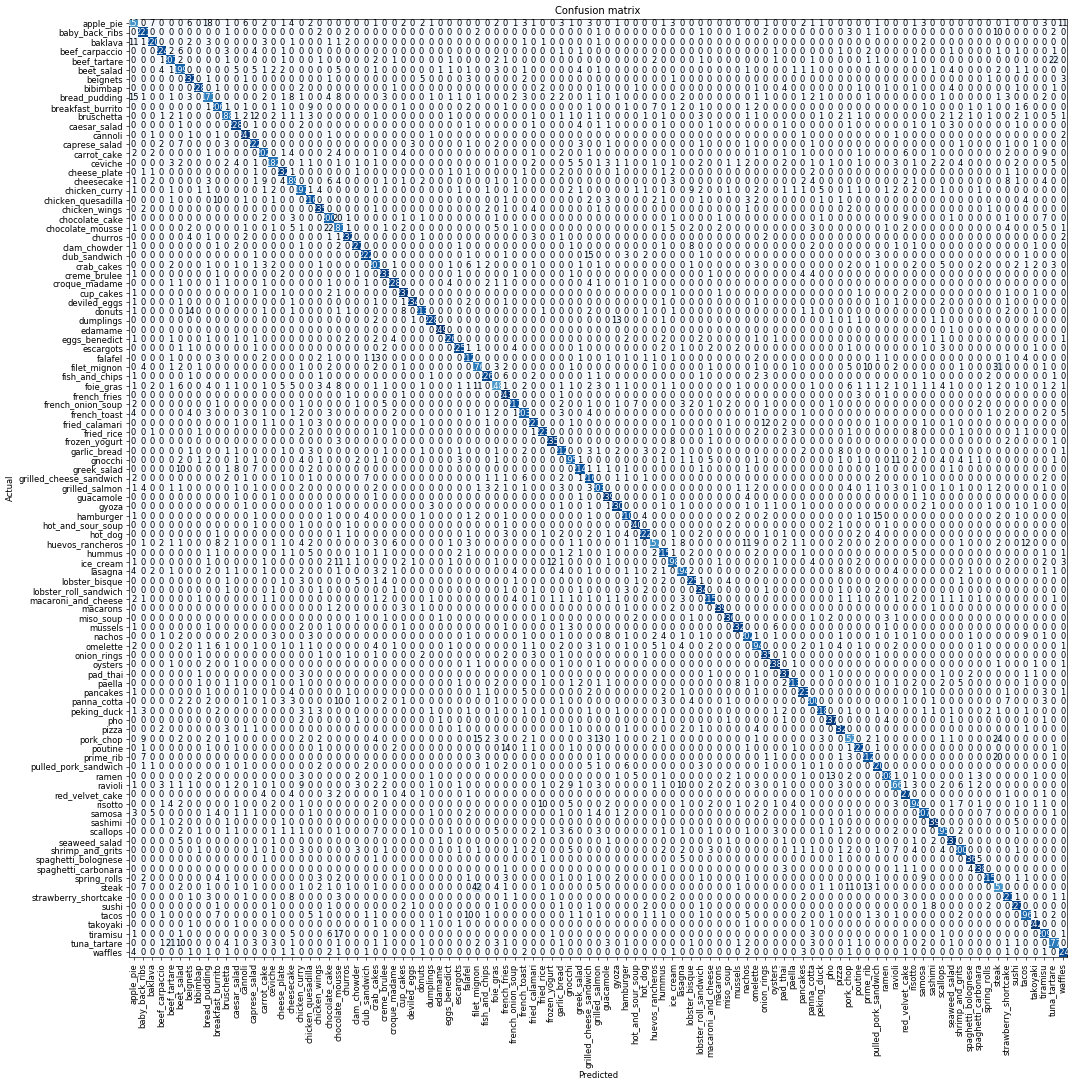

In [0]:
interp_test_tta.plot_confusion_matrix(figsize=(18,18), dpi=60)

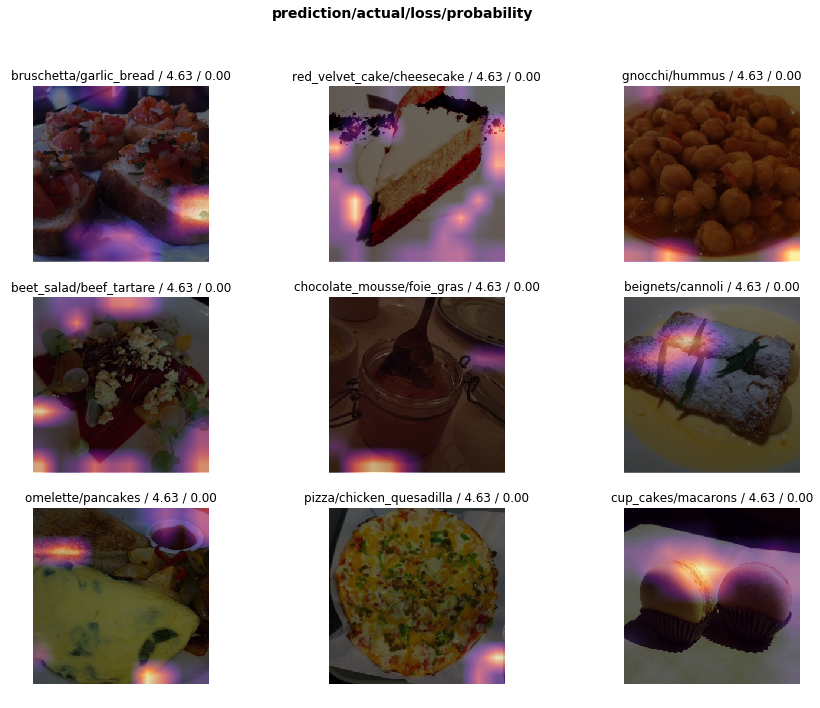

In [0]:
interp_test_tta.plot_top_losses(9, figsize=(15,11))

<BarContainer object of 101 artists>

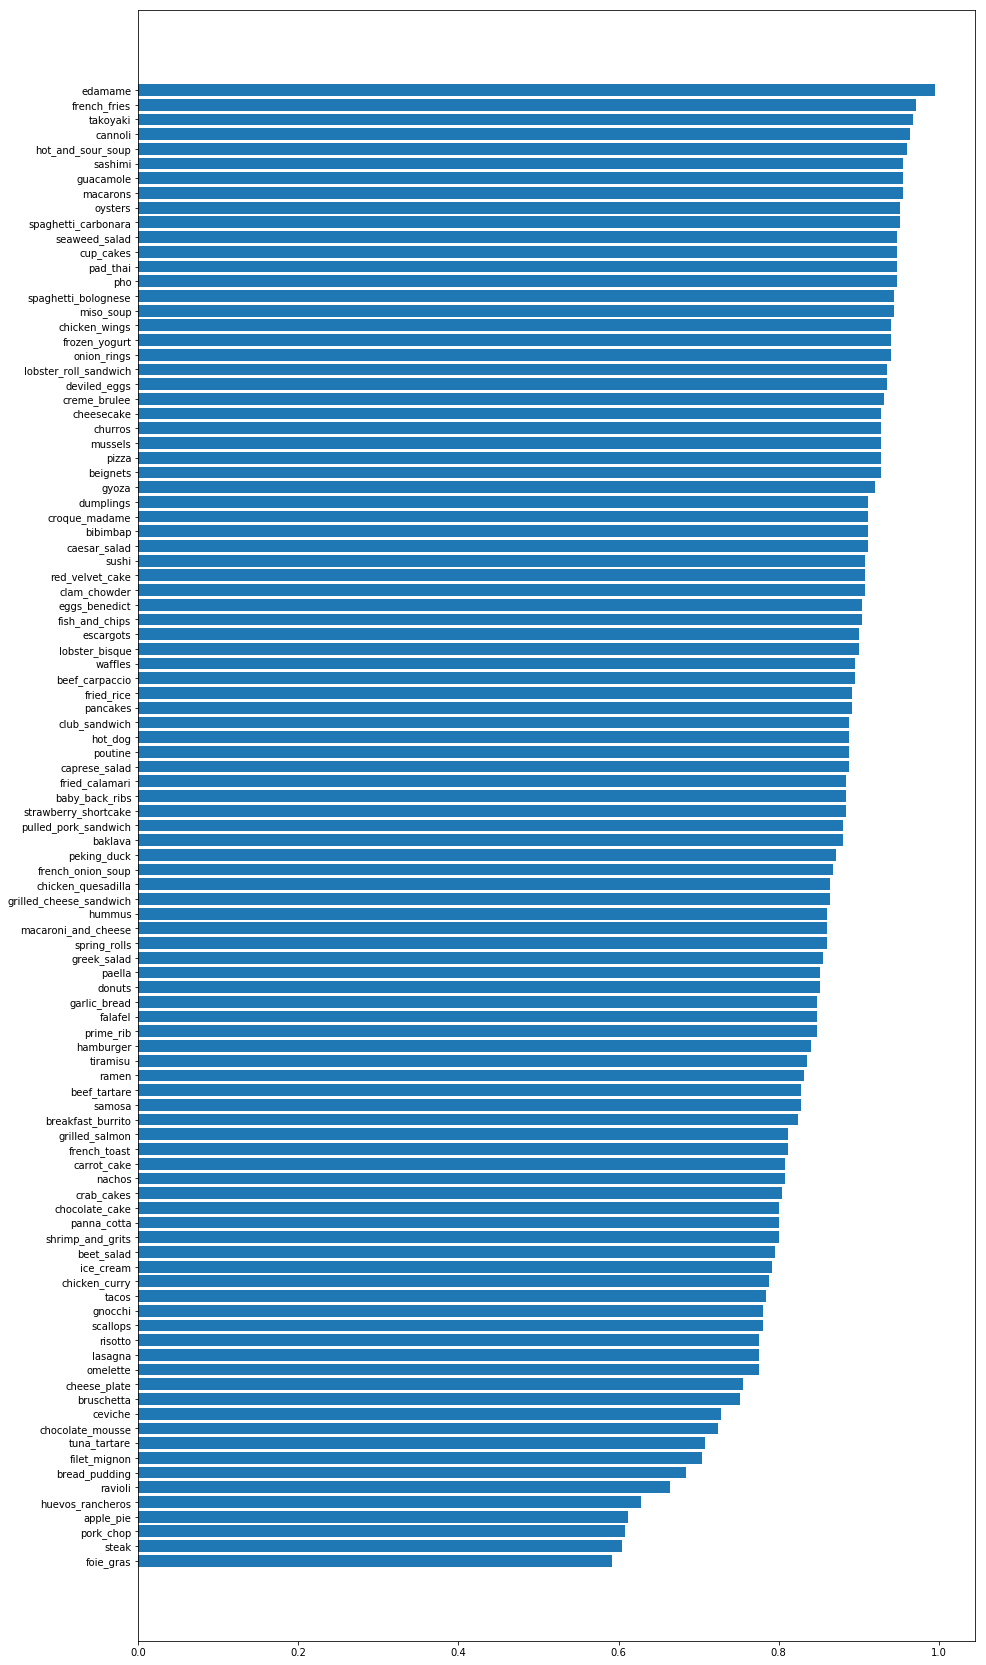

In [0]:
correct_class = correct[0,:].data.numpy()
class_acc = np.zeros((n_classes,))
for i in range(n_classes):
  a = interp_test_tta.y_true == i
  a = a.data.numpy()
  class_acc[i] = (np.sum(correct_class * a) / np.sum(a))
a = np.asarray(class_acc)
b = np.argsort(a)
c = np.unravel_index(b, b.shape)
fig = plt.figure(figsize=(15,30))
d = np.asarray(class_list)
plt.barh(d[c],a[c])

<BarContainer object of 101 artists>

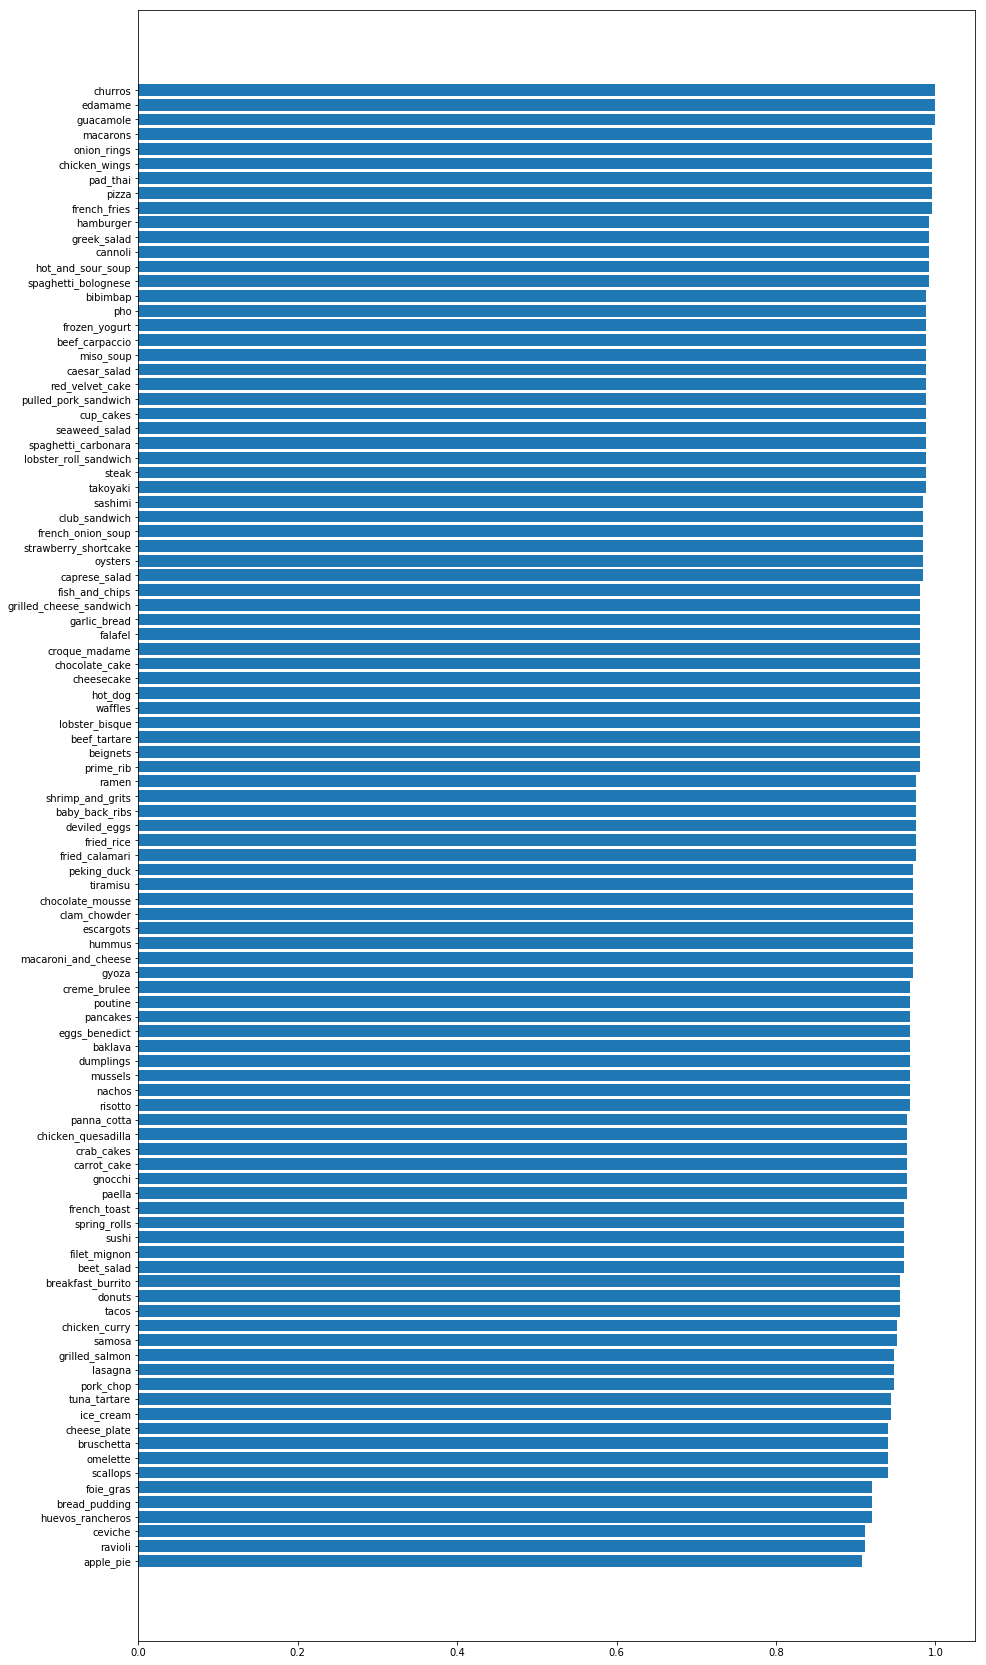

In [0]:
correct_class_top5 = correct[:5].float().sum(0, keepdim=True).data.numpy()
class_acc = np.zeros((n_classes,))
for i in range(n_classes):
  a = interp_test_tta.y_true == i
  a = a.data.numpy()
  class_acc[i] = (np.sum(correct_class_top5 * a) / np.sum(a))
a = np.asarray(class_acc)
b = np.argsort(a)
c = np.unravel_index(b, b.shape)
fig = plt.figure(figsize=(15,30))
d = np.asarray(class_list)
plt.barh(d[c],a[c])

## Conclusions

The model trained here reaches a top-1 accuracy of 85.56% and a top-5 accuracy of 97.12%.

So this model successfully reached the >85% target set by Fellowship.ai for their challenge.

I know some of why this model probably worked better than my previous implementations: including both average and max pooling, including batch normalization, different values for the dropout layers, and using a cyclic learning rate. However, I feel like there might be more to it.

This has definitely shown fastai to be a useful tool, and I look forward to finding out more about it as I take more of the lessons.
